In [1]:
import fastai
from fastai.vision import *
from fastai import *

### 从kaggle下载数据

In [2]:
# ! pip install kaggle --upgrade

In [3]:
path = Path("F:\\data\\kaggle")/'planet'
path.mkdir(parents= True,exist_ok = True)
path

WindowsPath('F:/data/kaggle/planet')

In [4]:
# ! mv kaggle.json C:\Users\Administrator\.kaggle

In [5]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}

# ! conda install -y -c haasad eidl7zip

# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

In [6]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}


7-Zip (A) 9.20  Copyright (c) 1999-2010 Igor Pavlov  2010-11-18

Processing archive: F:\data\kaggle\planet\train-jpg.tar.7z

Extracting  train-jpg.tar

Everything is Ok

Size:       665753600
Compressed: 629296207


In [4]:
path/'train-jpg.tar.7z'

NameError: name 'path' is not defined

### 读取label.csv

In [7]:
import pandas as pd

In [8]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


#### 观察数据

In [9]:
tfms = get_transforms(flip_vert= True,max_lighting=0.1,max_warp=0.,max_zoom=1.05)

In [10]:
random.seed(42)

In [11]:
src = (ImageItemList.from_csv(path,'train_v2.csv',folder='train-jpg', suffix='.jpg')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' '))

In [12]:
data = src.transform(tfms = tfms,size = 128).databunch().normalize(imagenet_stats)

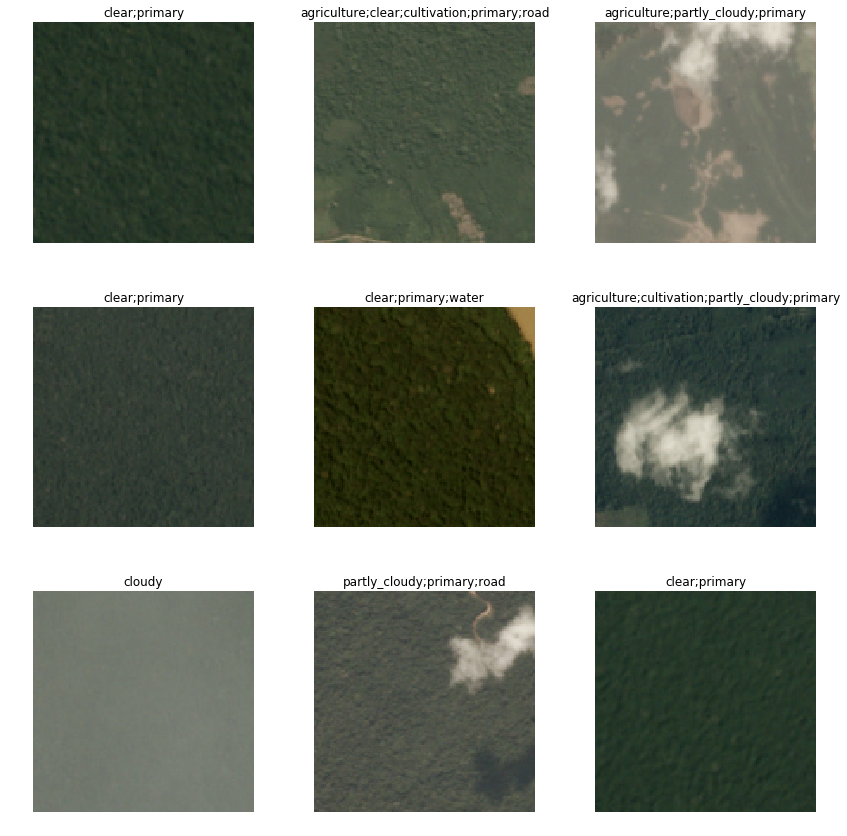

In [13]:
data.show_batch(rows = 3)

In [14]:
model = models.resnet18

In [15]:
acc_02 = partial(accuracy_thresh,thresh = 0.2)
f_score = partial(fbeta,thresh = 0.2)

In [16]:
learner = create_cnn(data,model,metrics=[acc_02,f_score])

In [17]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


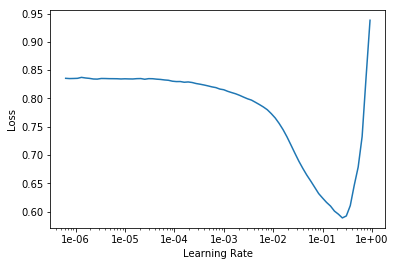

In [18]:
learner.recorder.plot()

In [19]:
lr = 2e-2

In [20]:
learner.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.129109,0.114103,0.944454,0.901170
2,0.127083,0.108217,0.952149,0.905362
3,0.110655,0.098611,0.949082,0.916551
4,0.101132,0.091743,0.951989,0.921035
5,0.100203,0.090146,0.952774,0.921529


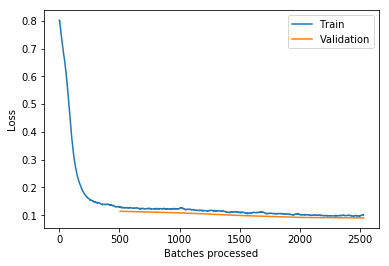

In [21]:
learner.recorder.plot_losses()

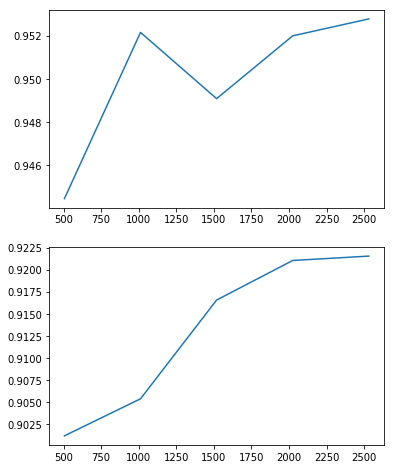

In [22]:
learner.recorder.plot_metrics()

In [23]:
learner.save('stage-1-rest18')

##### fine-tune the whole model

In [24]:
learner.unfreeze()

In [25]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


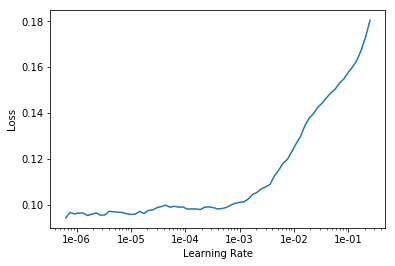

In [26]:
learner.recorder.plot()

In [27]:
learner.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.101361,0.098353,0.953443,0.916932
2,0.098776,0.092659,0.953246,0.918699
3,0.093946,0.088421,0.955361,0.921647
4,0.086507,0.086100,0.957847,0.924159
5,0.086051,0.084401,0.956248,0.925547


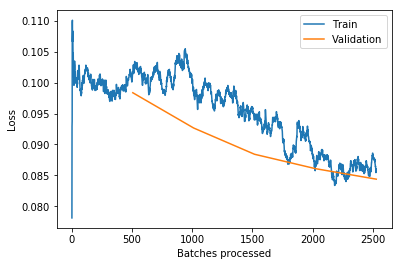

In [28]:
learner.recorder.plot_losses()

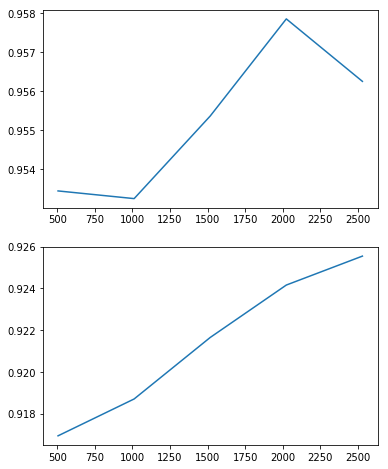

In [29]:
learner.recorder.plot_metrics()

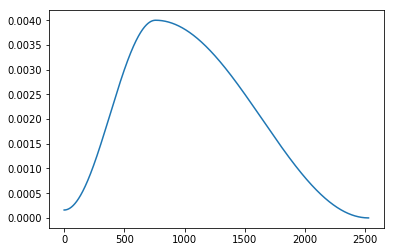

In [30]:
learner.recorder.plot_lr()

In [31]:
learner.save('stage-2-15')

#### 改变图片大小

In [32]:
data = src.transform(tfms = tfms,size = 256)

In [33]:
data = data.databunch()

In [34]:
data = data.normalize(imagenet_stats)

In [35]:
learner = create_cnn(data,arch = models.resnet18,metrics=[acc_02,f_score])

In [36]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


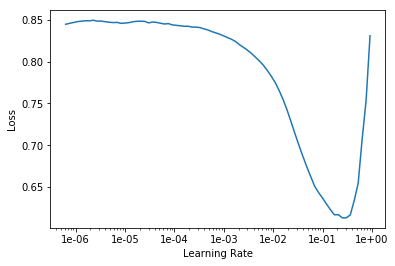

In [37]:
learner.recorder.plot()

In [38]:
lr = 1e-2

In [39]:
learner.fit_one_cycle(3,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.124990,0.107977,0.945304,0.904248
2,0.108644,0.096177,0.951008,0.914381
3,0.103470,0.091712,0.953443,0.920378


In [40]:
learner.save('stage-256-rest18')

In [41]:
learner.unfreeze()

In [42]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


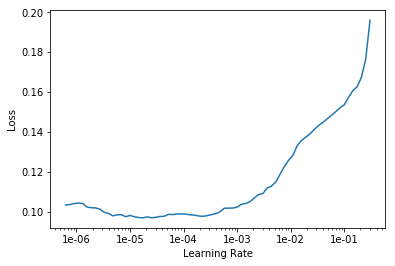

In [43]:
learner.recorder.plot()

In [44]:
learner.fit_one_cycle(5,slice(1e-5,lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.101855,0.093033,0.954140,0.918509
2,0.097865,0.092885,0.954155,0.915705
3,0.093030,0.085744,0.957643,0.925861
4,0.086682,0.083285,0.955761,0.928540
5,0.085152,0.081929,0.958275,0.929453
